# CV2 – Lab-Sessions: Simetry

Author: Pedro Guijas Bravo

## Imports

In [87]:
from skimage import io
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import numpy as np

## Load images

fotitis/brillo-solar.png
(512, 512)


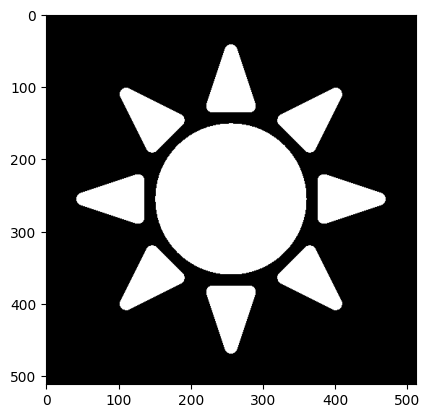

fotitis/pngimg.com - butterfly_PNG1046.png
(2000, 2381)


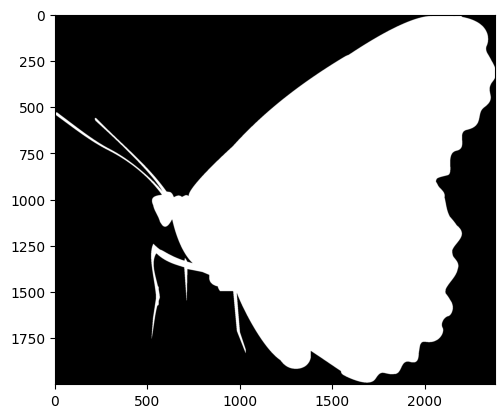

fotitis/linux.png
(479, 400)


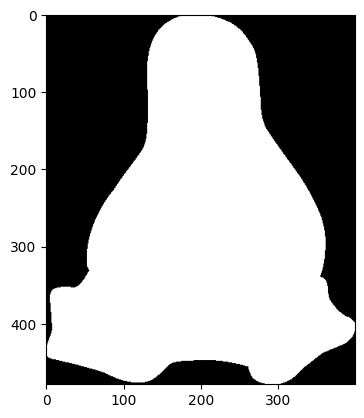

fotitis/wid.png
(516, 515)


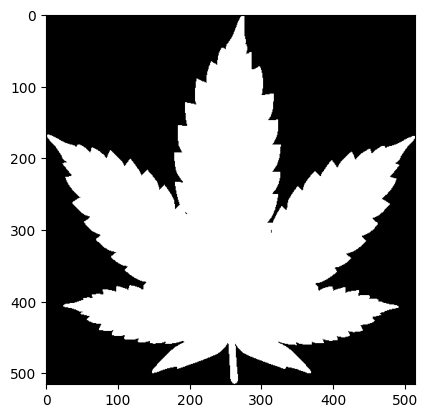

fotitis/1000x1000.png
(1000, 1000)


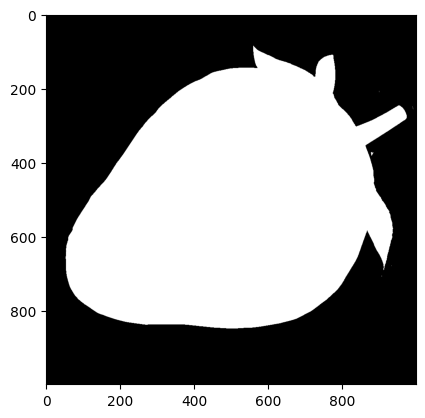

fotitis/Duck-Transparent-PNG.png
(1750, 1888)


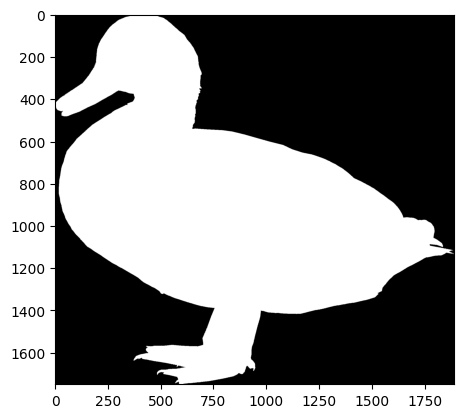

fotitis/tree.png
(600, 504)


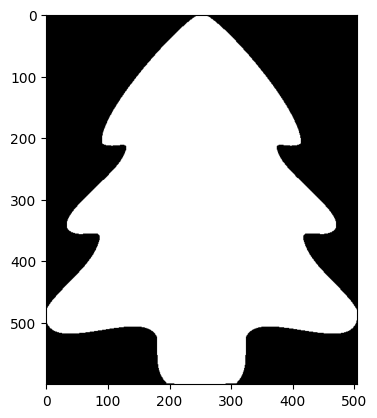

fotitis/whatsapp.png
(360, 360)


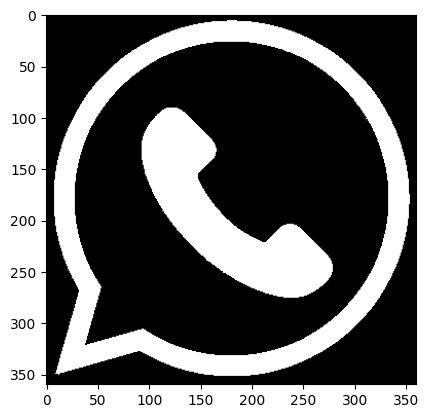

In [88]:
def load_alpha_image_as_binary(image_path):
    # Load an example image (fotitis/wide.png)
    image = io.imread(image_path)
    # Get only the alpha channel
    image = image[:,:,3]
    # Apply threshold
    image = image != 0
    return image

# Load visualize all images
def load_images(folder):
    images_path = glob.glob(folder + '/*.png')
    images = [load_alpha_image_as_binary(image) for image in images_path]
    for path,image in zip(images_path,images):
        print(path)
        print(image.shape)
        plt.imshow(image, cmap=plt.cm.gray)
        plt.show()
    return images

images = load_images('fotitis')

## Skeletonize images


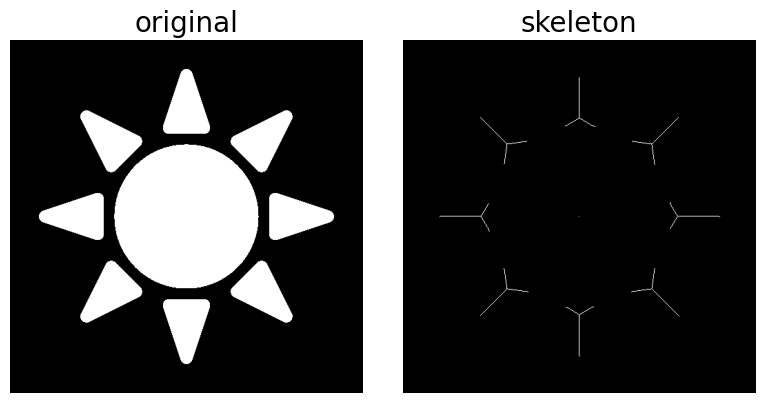

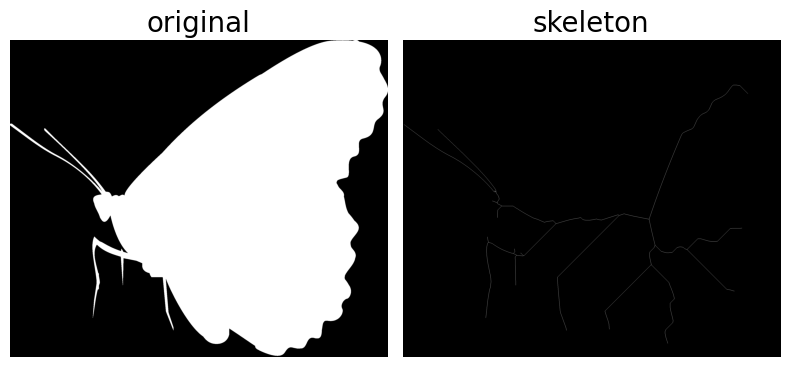

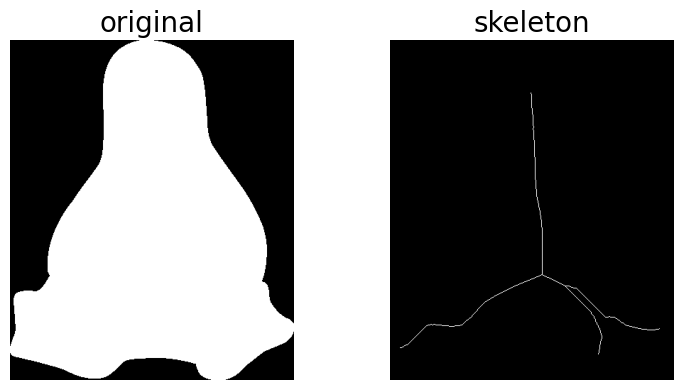

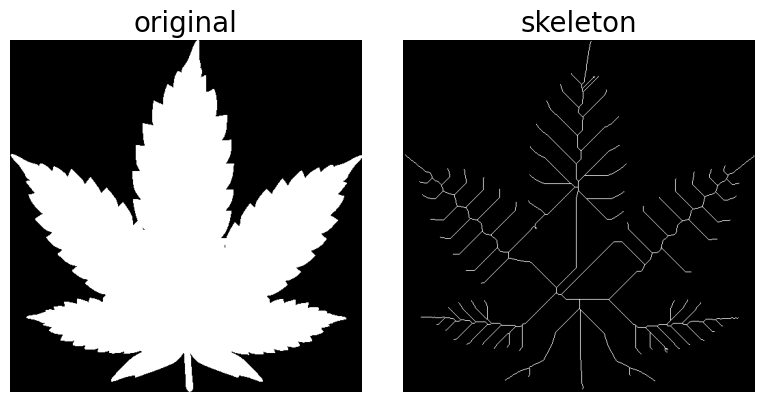

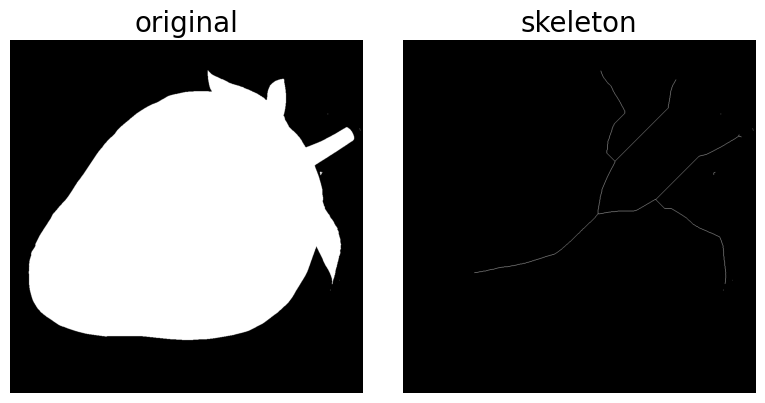

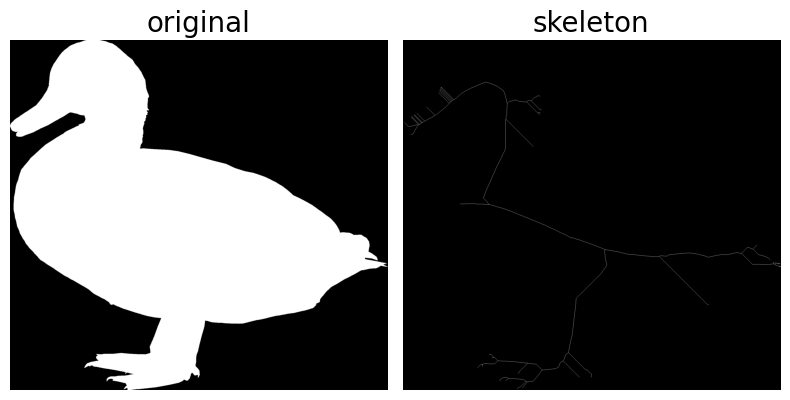

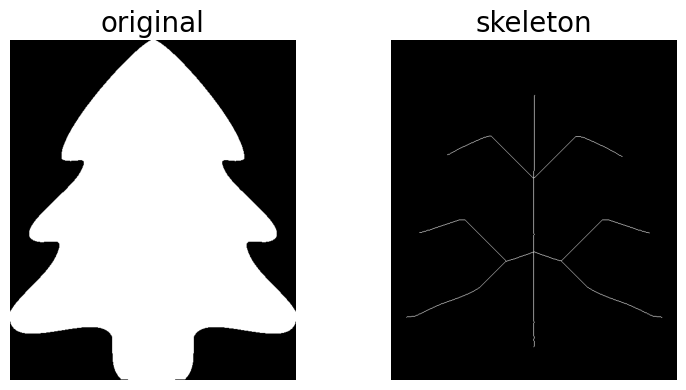

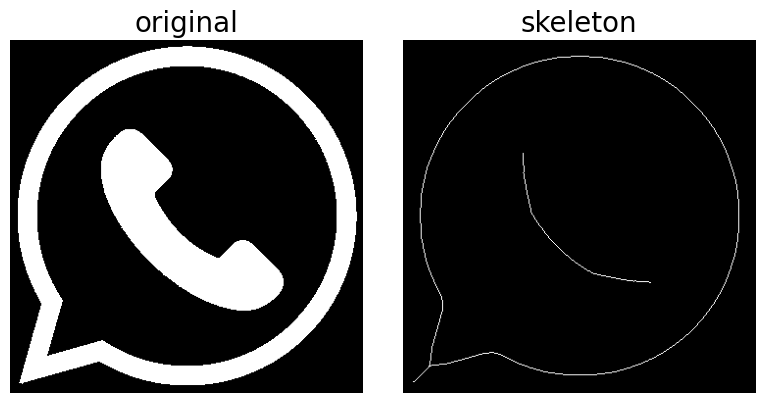

In [98]:
def skeletonize_images(images):
    skeletons = [skeletonize(image).astype("uint8") for image in images]
    for image, skeleton in zip(images,skeletons):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                                 sharex=True, sharey=True)

        ax = axes.ravel()

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[0].set_title('original', fontsize=20)

        ax[1].imshow(skeleton, cmap=plt.cm.gray)
        ax[1].axis('off')
        ax[1].set_title('skeleton', fontsize=20)

        fig.tight_layout()
        plt.show()
    return skeletons

skeletons = skeletonize_images(images)

## Find center points (centroid)

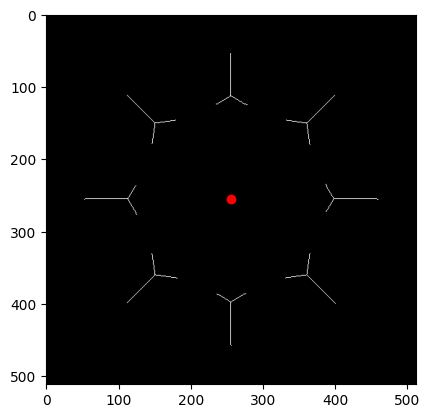

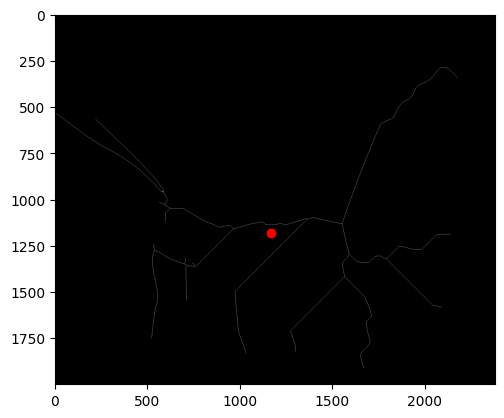

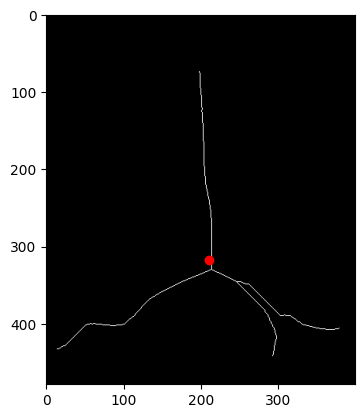

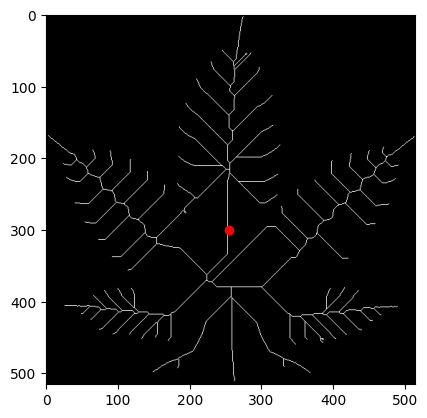

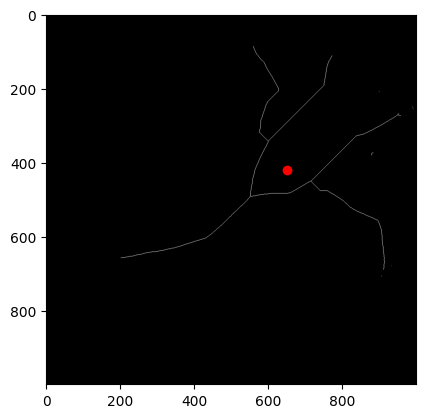

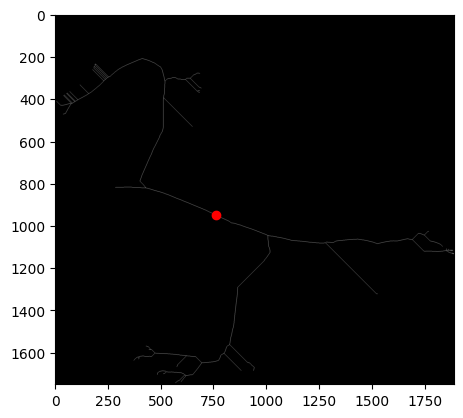

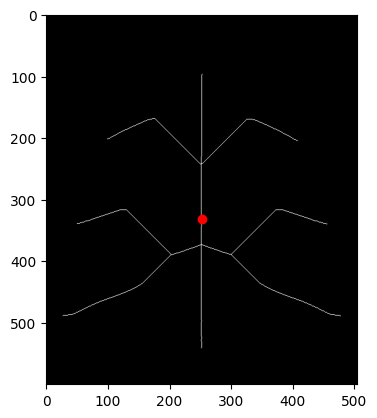

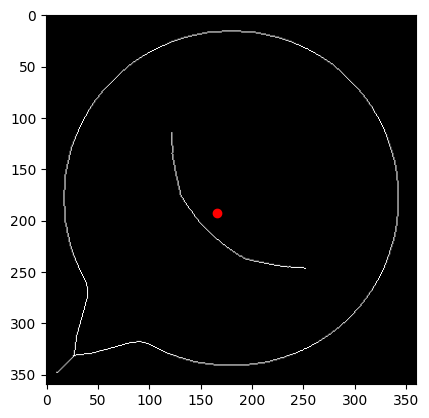

In [90]:
def find_centroid(images, debug=False):
    centroids = []
    for image in images:
        M = cv.moments(image.astype('uint8'))
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        centroids.append((cx,cy))
    if debug:
        for image,centroid in zip(images,centroids):
            plt.imshow(image, cmap=plt.cm.gray)
            plt.scatter(centroid[0],centroid[1],c='r')
            plt.show()
    return centroids

centroids = find_centroid(skeletons, debug=True)


## Estimate reflection line

In [91]:
#############################
## Useful functions
#############################

def angle_with_x_axis(pi, pj):
    # get the difference between point p1 and p2
    x, y = pi[0]-pj[0], pi[1]-pj[1] 
    
    if x == 0:
        return np.pi/2  
    
    angle = np.arctan(y/x)
    if angle < 0:
        angle += np.pi
    return angle

def midpoint(pi, pj):
    return (pi[0]+pj[0])/2, (pi[1]+pj[1])/2

In [126]:
#############################
## Mirror symmetry detection
#############################

# create SIFT object ((a feature detection algorithm)) 
detector = cv.SIFT_create()
detector = cv.ORB_create()
# create BFMatcher object
bf = cv.BFMatcher()

class MirrorSymmetry:
    def __init__(self, image, detector=detector):
        self.image = image.astype('uint8')
        self.centroid = find_centroid([image])[0]
        # SIFT only works with 8-bit images
        if self.image.max() <= 1:
            self.image = self.image*255
        # Flipped version of image 
        self.reflected_image = np.fliplr(self.image) 
        # keypoints and descriptors 
        self.kp1, self.des1 = detector.detectAndCompute(self.image, None) 
        self.kp2, self.des2 = detector.detectAndCompute(self.reflected_image, None)
        

    def run(self, visualize=True):
        matchpoints = self.find_matchpoints()
        points_r, points_theta = self.find_points_r_theta(matchpoints)
        if visualize: # visualize process in detail
            self.draw_matches(matchpoints, top = 10)
            self.draw_hex(points_r, points_theta)
        # find the best one with highest vote
        image_hexbin = plt.hexbin(points_r, points_theta, bins=200, cmap= plt.cm.Spectral_r) 
        sorted_vote = self.sort_hexbin_by_votes(image_hexbin)
        r, theta = self.find_coordinate_maxhexbin(sorted_vote, vertical=False)  

        self.draw_mirrorLine(r, theta, title="With Mirror Line")
     
    def find_matchpoints(self):
        # Match descriptors (original - reflected)
        matches = bf.knnMatch(self.des1, self.des2, k=2)
        # Equivalent so keep only one point
        matchpoints = [item[0] for item in matches] 
        # sort to determine the dominant symmetries
        # Distance between descriptors. The lower, the better it is.
        matchpoints = sorted(matchpoints, key = lambda x: x.distance) 
        return matchpoints
    
    # Get r, tehta of the midpoints of all pair of symmetric features
    def find_points_r_theta(self, matchpoints:list):
        points_r = [] 
        points_theta = []
        for match in matchpoints:
            point = self.kp1[match.queryIdx]  # queryIdx is an index into one set of keypoints, (origin image)
            mirpoint = self.kp2[match.trainIdx] # trainIdx is an index into the other set of keypoints (fliped image)
            # Normalise orientation
            mirpoint.angle = np.deg2rad(mirpoint.angle) 
            mirpoint.angle = np.pi - mirpoint.angle
            # convert angles to positive 
            if mirpoint.angle < 0.0:   
                mirpoint.angle += 2*np.pi
            # Coordinates of the keypoints -> change x, not y
            mirpoint.pt = (self.reflected_image.shape[1]-mirpoint.pt[0], mirpoint.pt[1]) 
            # The angle this line subtends with the x-axis.
            theta = angle_with_x_axis(point.pt, mirpoint.pt)  
            # midpoit: image centred co-ordinates of the mid-point of the line joining pi and pj
            xc, yc = midpoint(point.pt, mirpoint.pt) 
            r = xc*np.cos(theta) + yc*np.sin(theta)  
            points_r.append(r)
            points_theta.append(theta)
        # returning polar coordinates
        return points_r, points_theta 

    def draw_matches(self, matchpoints, top=10):
        img = cv.drawMatches(self.image, self.kp1, self.reflected_image, self.kp2, matchpoints[:top], None, flags=2) 
        plt.imshow(img, cmap=plt.cm.gray); 
        plt.title("Top {} pairs of symmetry points".format(top))
        plt.show() 
        
    def draw_hex(self, points_r: list, points_theta: list):
        # Make a 2D hexagonal binning plot of points r and theta 
        _ = plt.hexbin(points_r, points_theta, bins=200, cmap= plt.cm.Spectral_r) 
        plt.colorbar() # add color bar
        plt.show()
    
    # Try to find the x and y coordinates of the hexbin with max count
    def find_coordinate_maxhexbin(self, sorted_vote, vertical):
        for k, _ in sorted_vote.items():
            # if mirror line is vertical, return the highest vote
            if vertical:
                return k[0], k[1]
            # otherwise, return the highest vote, whose y is not 0 or pi
            else:
                if k[1] == 0 or k[1] == np.pi:
                    continue
                else:
                    return k[0], k[1]
            
    # Sort hexbins by decreasing count. (lower vote)
    def sort_hexbin_by_votes(self, image_hexbin):
        counts = image_hexbin.get_array()
        verts = image_hexbin.get_offsets() # coordinates of each hexbin
        output = {}
        
        for offc in range(verts.shape[0]):
            binx,biny = verts[offc][0],verts[offc][1]
            if counts[offc]:
                output[(binx,biny)] = counts[offc]
        return {k: v for k, v in sorted(output.items(), key=lambda item: item[1], reverse=True)}
                              

    # Draw mirror line based on r theta polar co-ordinate                          
    def draw_mirrorLine(self, r, theta, title:str): 
        # draw plot 
        plt.imshow(self.image, cmap=plt.cm.gray)
        # set plot size to image size
        plt.axis('off') 
        # Draw line in the image
        f = lambda y: (r-y*np.sin(theta))/np.cos(theta)
        y = np.linspace(0, self.image.shape[0], 1000)
        x = f(y)
        plt.plot(x, y, 'r-')
        # Plot centroid
        plt.scatter(self.centroid[0],self.centroid[1],c='r')
        plt.title(title)
        plt.show()

## Experiments on the benchmark suite

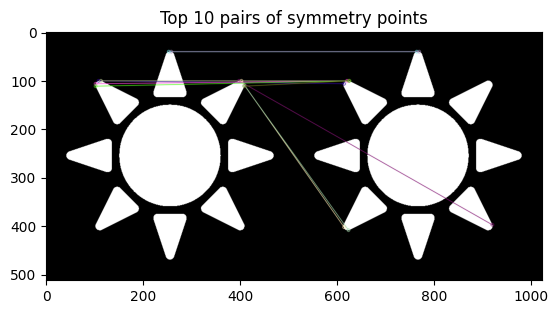

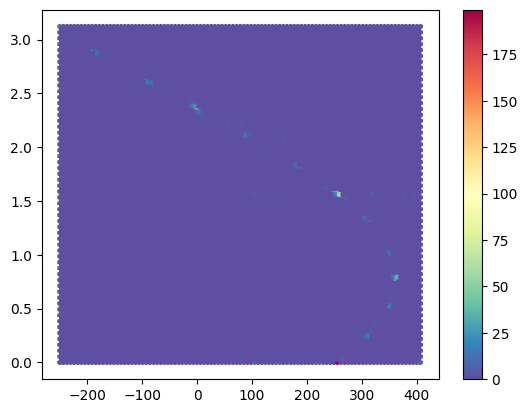

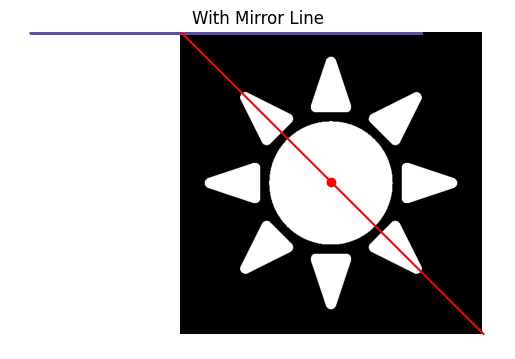

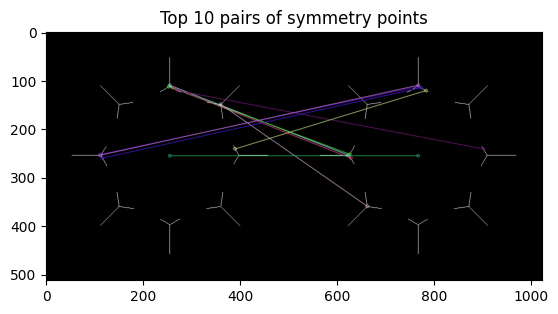

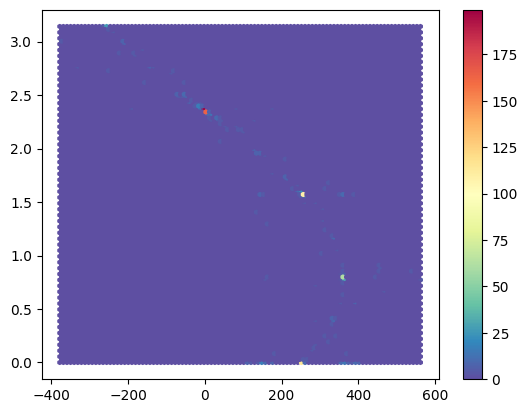

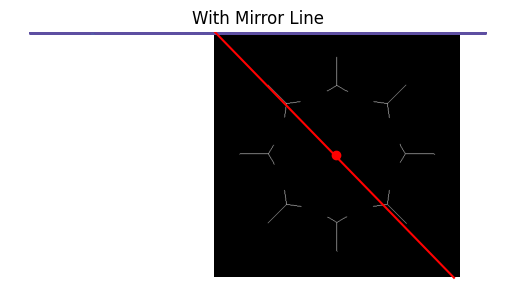

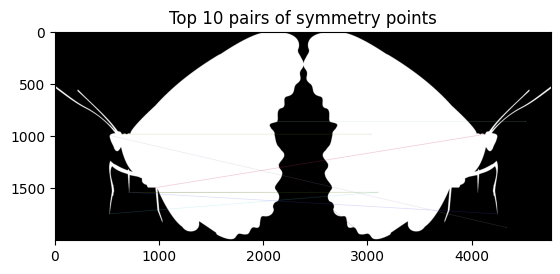

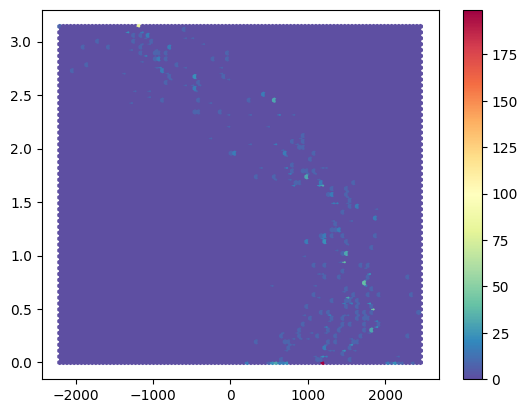

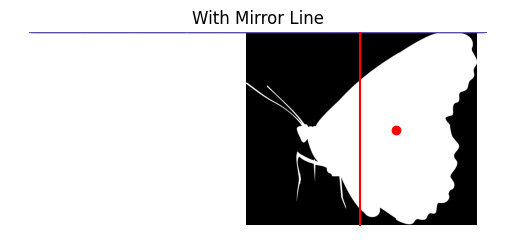

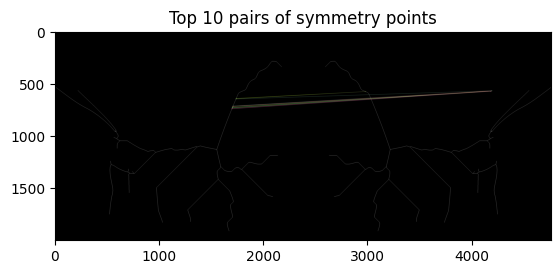

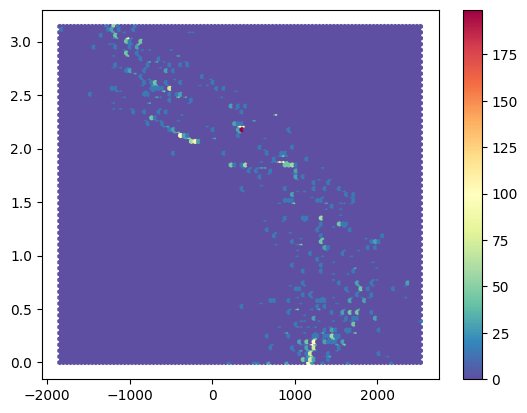

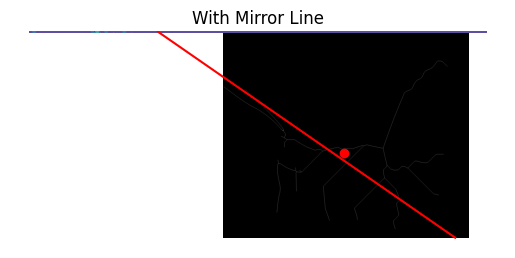

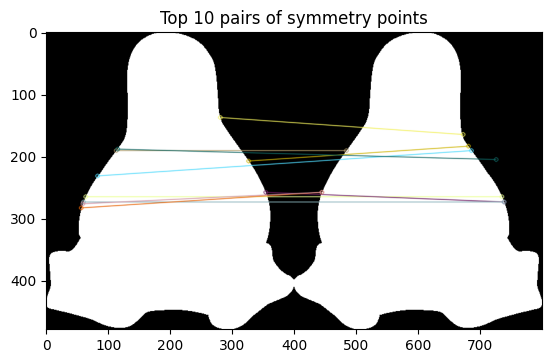

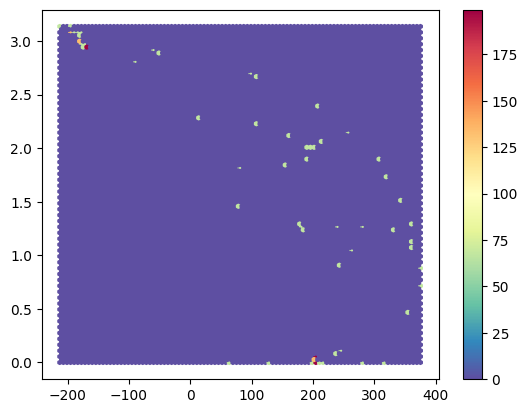

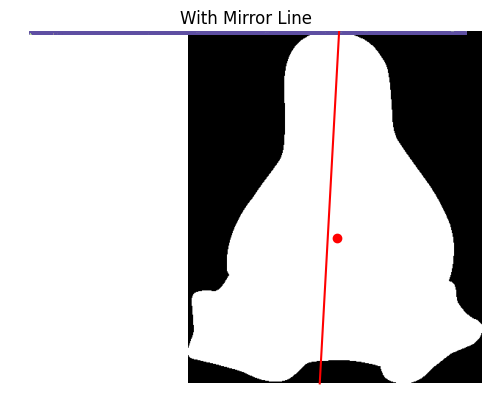

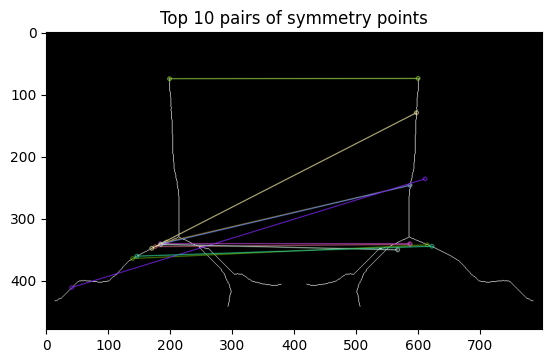

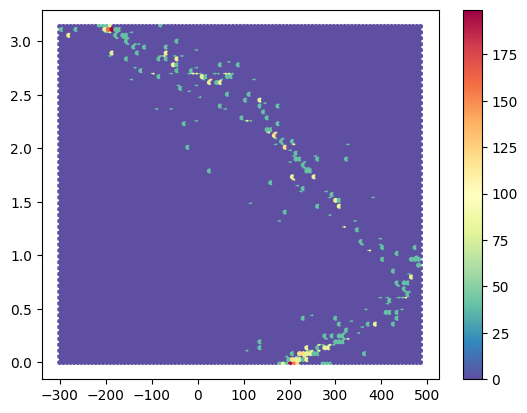

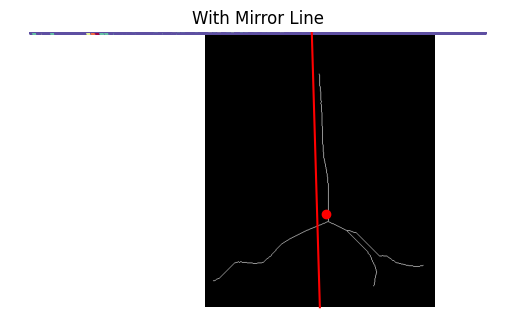

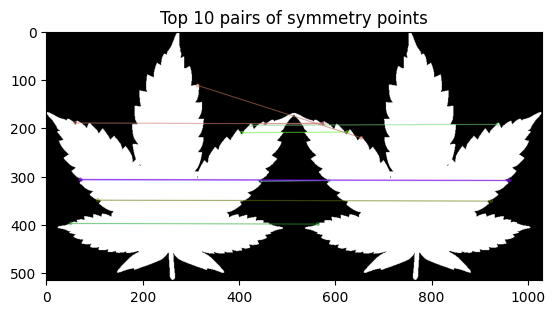

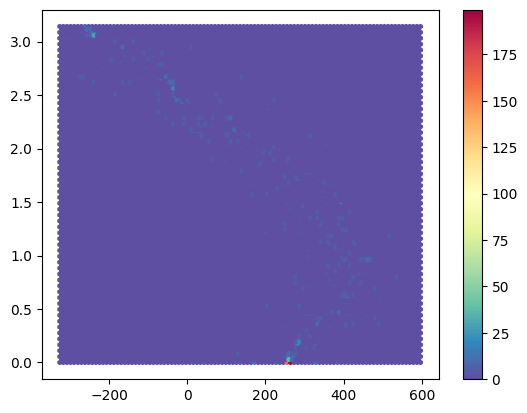

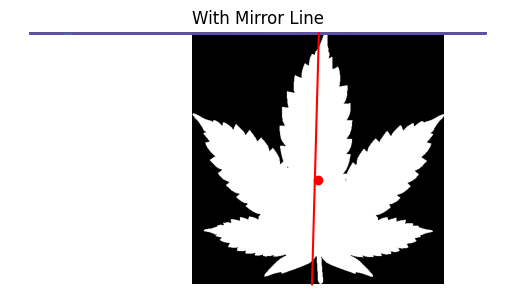

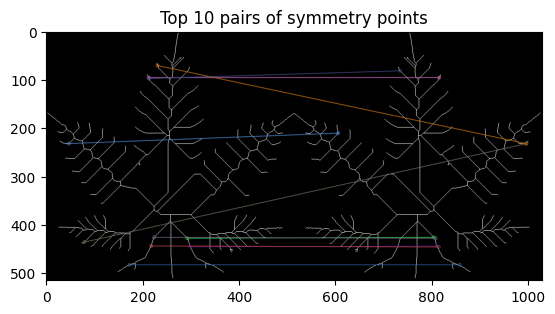

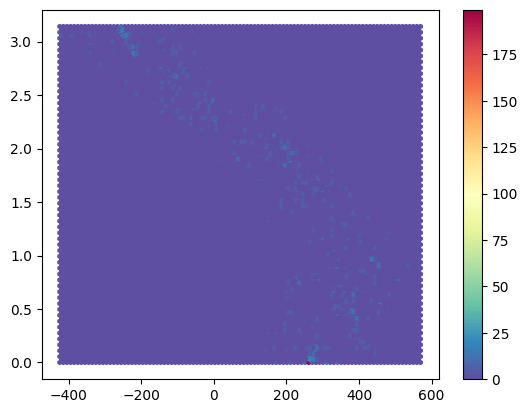

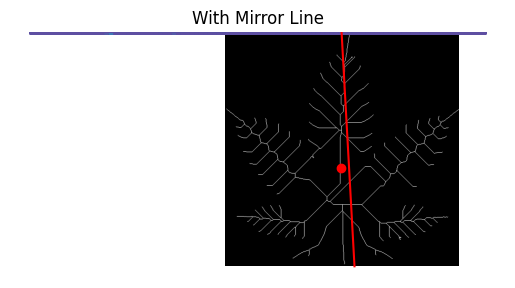

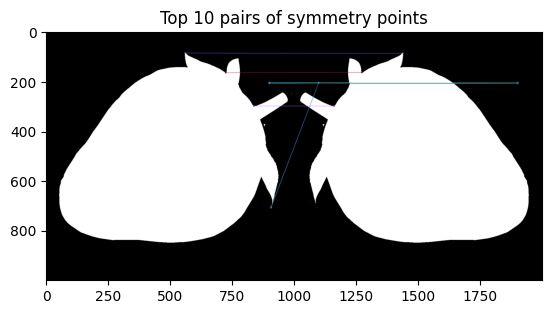

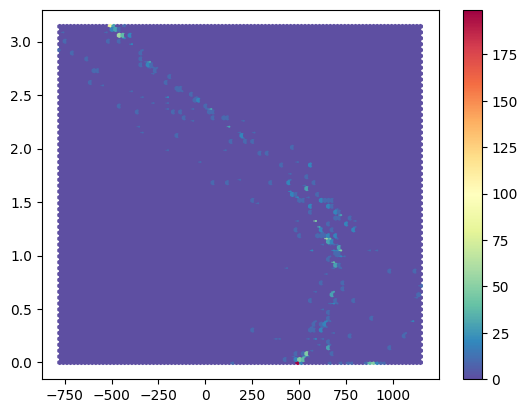

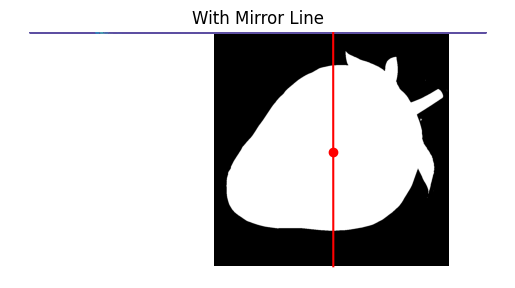

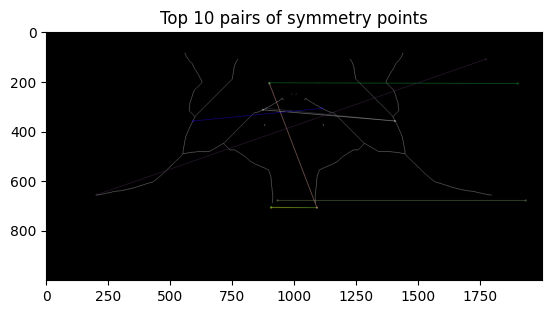

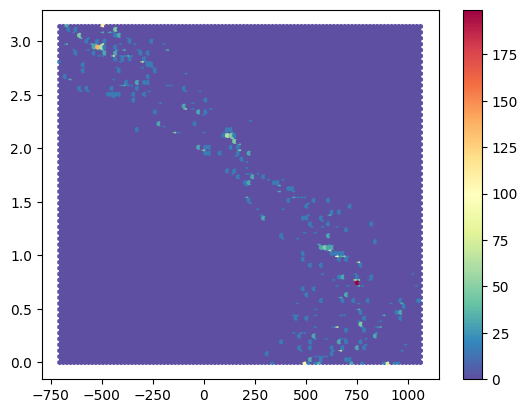

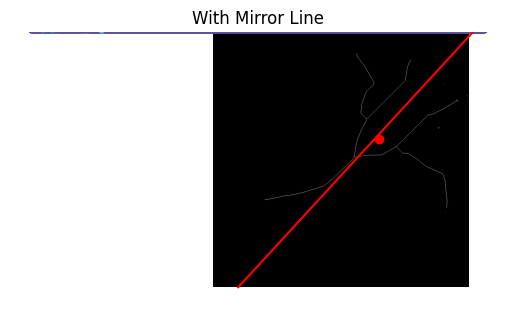

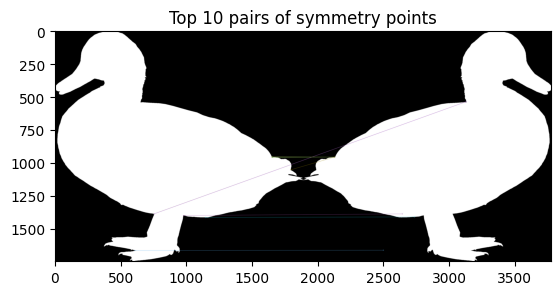

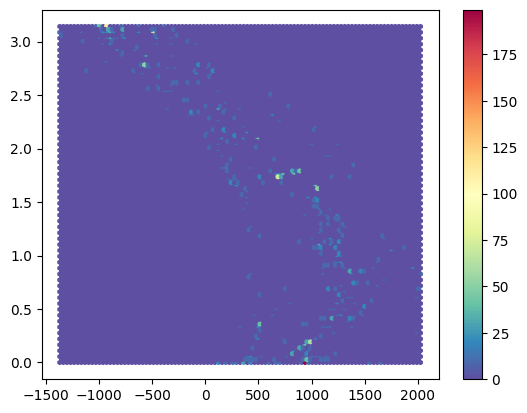

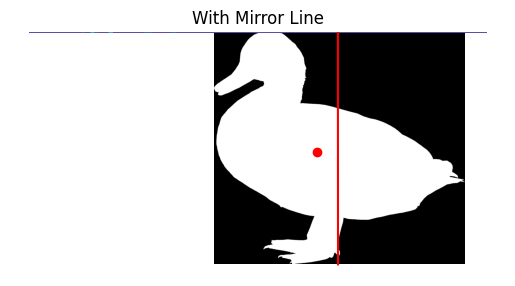

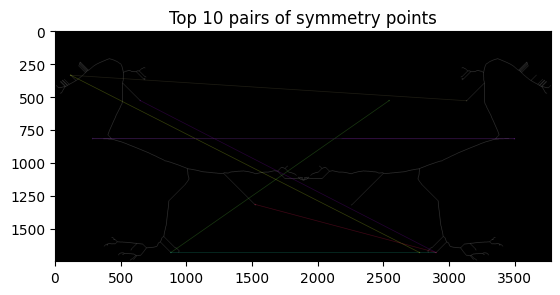

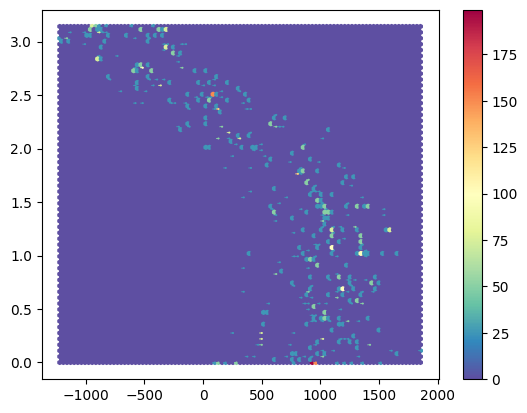

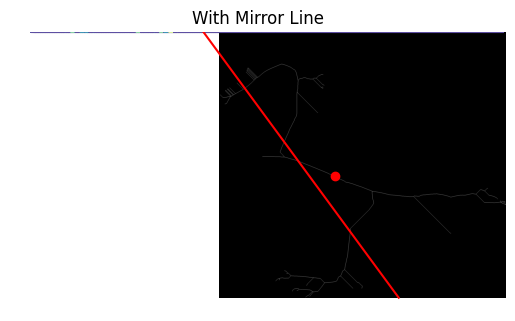

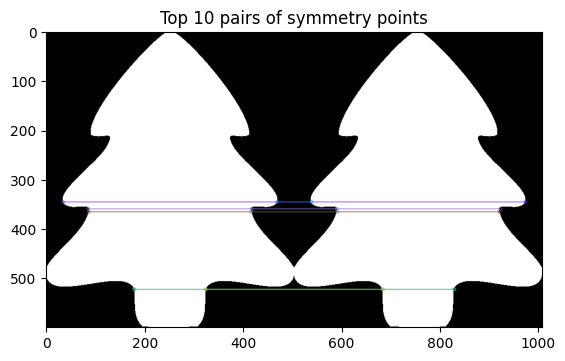

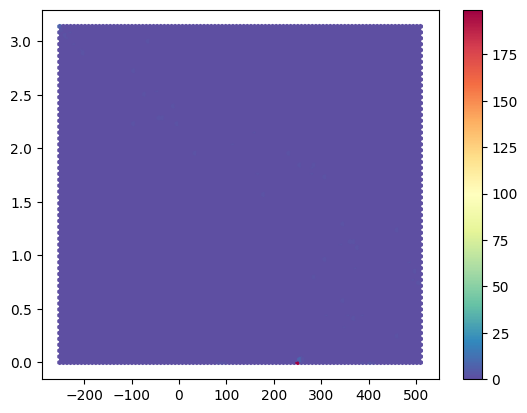

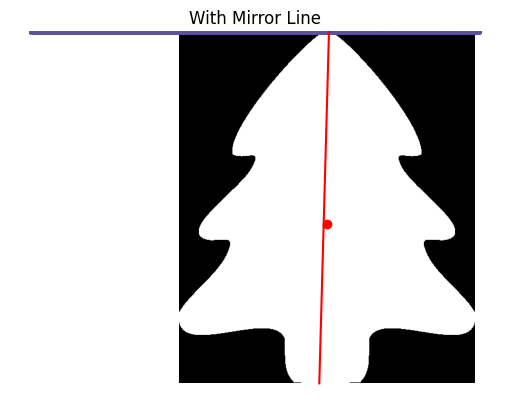

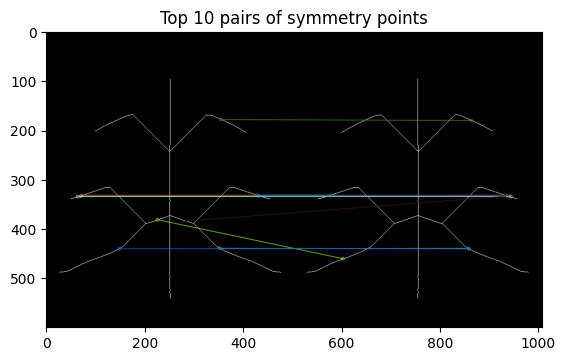

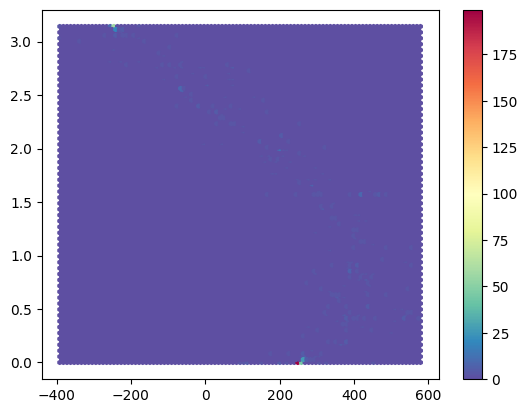

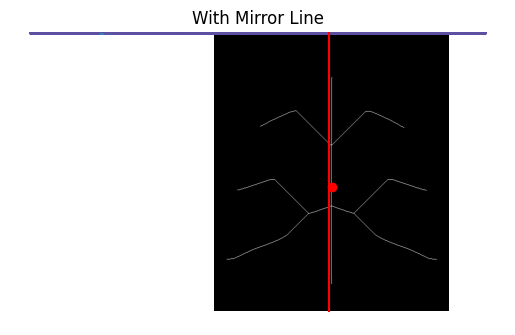

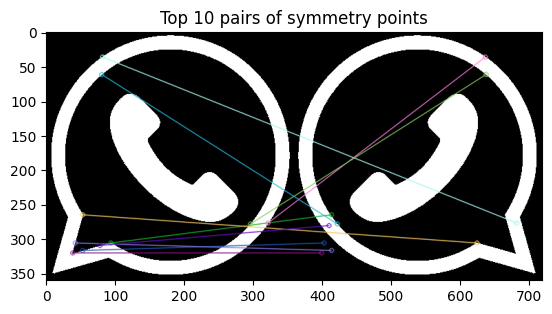

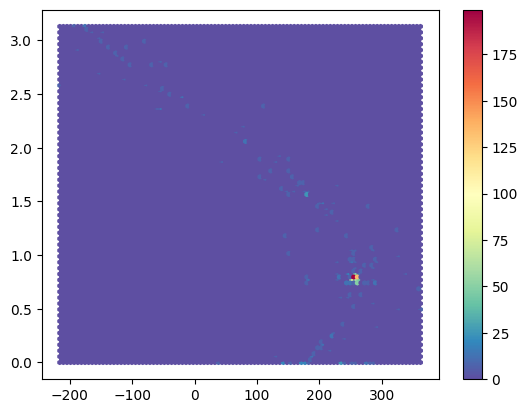

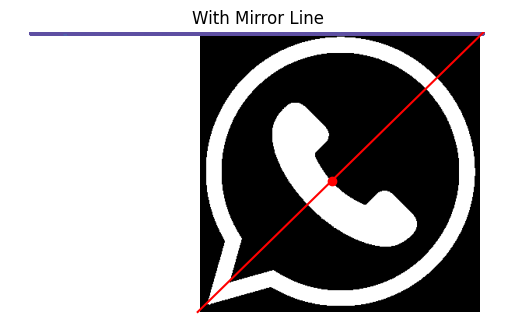

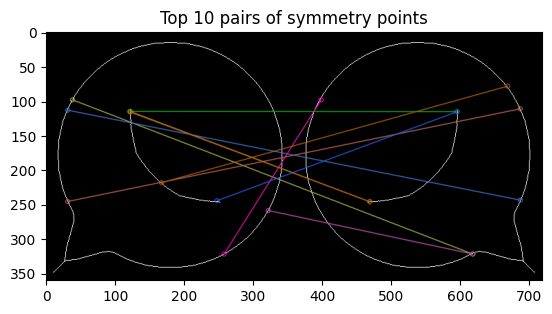

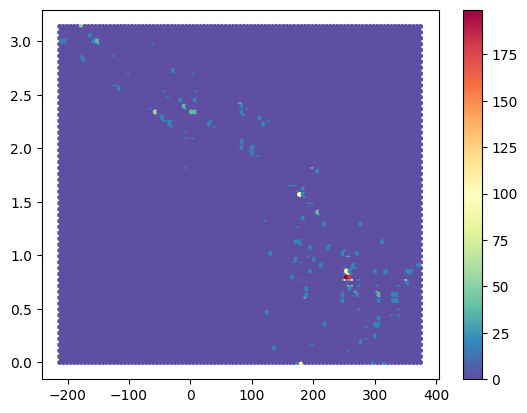

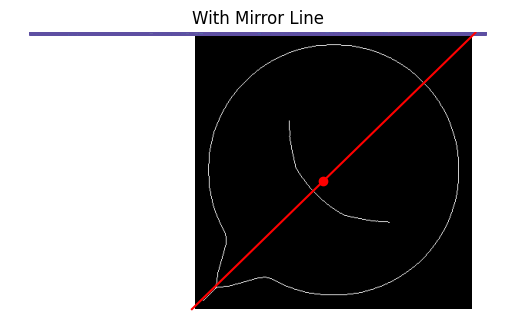

In [129]:
# Execution on original images
for img,sk in zip(images,skeletons):
    mirror = MirrorSymmetry(img)
    mirror.run()
    mirror = MirrorSymmetry(sk)
    mirror.run()

## Results

Once the results have been obtained, it has been observed that although most of the results are correct and pass through or really near to the centroid of the image. Likewise, the results between the original image and the skeleton have a high similarity, however, in some images such as the strawberry, the linux penguin or the butterfly, the line of symmetry is considered somewhat more accurate for the executions whose input image is the skeleton of the original image. 

In addition, it should be emphasized that the importance of the detector used is high, in this case, the run shown uses ORB, but other detectors such as SIFT, SURF, BRISK, etc. have been tested and the results have been found to be considerably worse. For example, for the whatsapp logo SIFT locates the line of symmetry with the vertical axis, while ORB locates it at a perfect angle. In addition, SIFT presents a terrible result with skeletons, because being images practically devoid of content except for a simple and thin line, this detector is not able to detect any point of interest, failing the execution of the algorithm.

Therefore, we conclude that the performance is adequate, especially, as mentioned above, when using ORB and the skeleton of the original image.